<a href="https://colab.research.google.com/github/respect5716/Deep-Learning-Paper-Implementation/blob/master/02_Vision/Implicit%20Maximum%20Likelihood%20Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implicit Maximum Likelihood Estimation

## 0. Paper

### Info
* TItle : Implicit Maximum Likelihood Estimation
* Author : Ke Li, Jitendra Malik
* Publication : [link](https://arxiv.org/abs/1809.09087)

### Summary
* real sample과 가까운 generated sample을 찾은 후, real sample에 더 가까워지도록 학습
* GAN보다 안정적이고 다양한 sample 생성 가능

### Differences
* filter number : 512 -> 256
* knn algorithm : DCI -> Vanilla

## 1. Setting

In [ ]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# GPU Setting
!nvidia-smi

print(f'tensorflow version : {tf.__version__}')
print(f'available GPU list : {tf.config.list_physical_devices("GPU")}')

Fri Jul  3 12:50:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [96]:
# Hyperparameters
CONFIG = {
    'base_dir' : '/content/drive/Shared drives/Yoon/Project/Doing/Deep Learning Paper Implementation',
    'latent_dim' : 1000,
    'fake_batch_size' : 1024,
    'real_batch_size' : 32,
    'epoch_size' : 300,
}

## 2. Data

In [97]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, data_x, shuffle):
        self.data_x = data_x
        self.shuffle = shuffle

        self.idx = 0
        self.on_epoch_end()
    
    def __len__(self):
        return np.ceil(len(self.data_x) / CONFIG['real_batch_size']).astype(np.int32)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indices = np.random.permutation(len(self.data_x))
        else:
            self.indices = np.arange(len(self.data_x))
    
    def __getitem__(self, idx):
        batch_idx = self.indices[CONFIG['real_batch_size']*idx : CONFIG['real_batch_size']*(idx+1)]
        batch_x = self.data_x[batch_idx]
        batch_x = batch_x.astype(np.float32) / 255
        return batch_x

    def next(self):
        if self.idx == self.__len__():
            self.idx = 0
            self.on_epoch_end()
        
        batch_x = self.__getitem__(self.idx)
        return batch_x

In [98]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

In [99]:
train_dataset = Dataset(train_x, True)

In [100]:
batch_x = train_dataset.next()

In [101]:
batch_x.shape

(32, 32, 32, 3)

## 3. Model

In [102]:
def build_network():
    def _block(x, n):
        x = tf.keras.layers.Conv2D(n, (4,4), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = tf.keras.layers.UpSampling2D()(x)
        return x

    inputs = tf.keras.layers.Input((CONFIG['latent_dim'],))
    x = tf.keras.layers.Dense(4*4*256)(inputs)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Reshape((4, 4, 256))(x)
    x = _block(x, 256)
    x = _block(x, 256)
    x = _block(x, 256)
    outputs = tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)

    network = tf.keras.Model(inputs, outputs)
    network.compile(
        loss = 'mse',
        optimizer = tf.keras.optimizers.Adam()
    )
    return network

In [103]:
network = build_network()
network.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 1000)]            0         
_________________________________________________________________
dense_9 (Dense)              (None, 4096)              4100096   
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 4, 4, 256)         1048832   
_________________________________________________________________
batch_normalization_27 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 4, 4, 256)         0   

## 4. Train

In [104]:
for ep in range(1, CONFIG['epoch_size']+1):
    random_vec = np.random.normal(size=(CONFIG['fake_batch_size'], 1000))
    generated = network.predict(random_vec)
    generated_flatten = np.reshape(generated, (CONFIG['fake_batch_size'], -1))

    for _ in range(CONFIG['fake_batch_size'] // CONFIG['real_batch_size']):
        real = train_dataset.next()
        real_flatten = np.reshape(real, (CONFIG['real_batch_size'], -1))
    
        sample_idx = [np.argmin(np.mean(np.square(i - generated_flatten), axis=-1)) for i in real_flatten]
        sample_x = random_vec[sample_idx]
        loss = network.train_on_batch(sample_x, real)

    if ep % 10 == 0:
        print(f'EP : {str(ep).zfill(3)} | Loss : {loss:.4f}')


EP : 010 | Loss : 0.0014
EP : 020 | Loss : 0.0006
EP : 030 | Loss : 0.0004
EP : 040 | Loss : 0.0003
EP : 050 | Loss : 0.0003
EP : 060 | Loss : 0.0002
EP : 070 | Loss : 0.0002
EP : 080 | Loss : 0.0002
EP : 090 | Loss : 0.0002
EP : 100 | Loss : 0.0001
EP : 110 | Loss : 0.0001
EP : 120 | Loss : 0.0001
EP : 130 | Loss : 0.0001
EP : 140 | Loss : 0.0001
EP : 150 | Loss : 0.0001
EP : 160 | Loss : 0.0001
EP : 170 | Loss : 0.0001
EP : 180 | Loss : 0.0001
EP : 190 | Loss : 0.0001
EP : 200 | Loss : 0.0001
EP : 210 | Loss : 0.0001
EP : 220 | Loss : 0.0001
EP : 230 | Loss : 0.0001
EP : 240 | Loss : 0.0001
EP : 250 | Loss : 0.0001
EP : 260 | Loss : 0.0000
EP : 270 | Loss : 0.0000
EP : 280 | Loss : 0.0000
EP : 290 | Loss : 0.0000
EP : 300 | Loss : 0.0000


## 5. Test

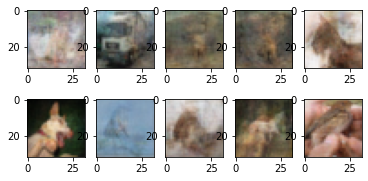

In [109]:
random_vec = np.random.normal(size=(10, 1000))
generated = network.predict(random_vec)

fig, ax = plt.subplots(2, 5, figsize=(6, 3))
for idx, i in enumerate(ax.flat):
    i.imshow(generated[idx])